# Training Data Picking Tool - Setup

## Imports

In [1]:
%matplotlib notebook
import os

import numpy as np
import pandas as pd
import xarray as xr

from sklearn import preprocessing
from sklearn import svm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.colors as colors
import matplotlib.patches as mpatches

import gdal

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider, Dropdown
from IPython.display import display

from skimage import exposure
from scipy.signal import lfilter

import datetime

import warnings

## function: getData
This code is specific to the intermediate output files from Peter's urban change algorithm.

In [2]:
def getData(study_area):
    """A quick helper function to load the output files from Peter's code for the given location.
    It returns and Xarray of the landsat data for that study area."""
    # build a list of all files in the directory (ie the folder for that location)
    location = '../' + study_area + '/'
    files = os.listdir(location)

    # build a list of all the NBAR*.img file names and which bands they represent
    NBARfiles = []
    bands = []
    for file in files:
        if file[-4::] == '.img' and file[0:4] == 'NBAR':
            NBARfiles.append(file)
            bands.append(file.split('NBAR_')[1].split('.img')[0])

    # open all the .img files with NBAR in the name, convert to numpy array, swap axes so order is (x, y, t)
    # and save to dict
    raw_data = {}
    for i in range(len(NBARfiles)):
        raw_data[bands[i]] = gdal.Open(location + NBARfiles[i]).ReadAsArray().swapaxes(0,2)
#     num_scenes = len(raw_data['red'][0][0])   # delete this?

    # build a list of all the dates represented by each band in the NBAR files
    # reuse the list of NBAR file names, but this time access the .hdr file
    in_dates = False
    dates = []
    for line in open(location + NBARfiles[0].split('.img')[0] + '.hdr'):
        if line[0] == '}':
            continue
        if in_dates:
            dates.append(line.split(',')[0].strip())
        if line[0:10] == 'band names':
            in_dates = True

    # save list of satellite originated bands
    sat_bands = bands.copy()

    # add the yet to be calculated derivative bands to the overall bands list
    bands += ['cloud_mask']

    # building the Xarray
    # define the size for the numpy array that will hold all the data for conversion into XArray
    x = len(raw_data['red'])
    y = len(raw_data['red'][0])
    t = len(raw_data['red'][0][0])
    n = len(bands)

    # create an empty numpy array of the correct size
    alldata = np.zeros((x, y, t, n), dtype=np.float32)

    # populate the numpy array with the satellite data
    # turn all no data NBAR values to NaNs
    for i in range(len(sat_bands)):
        alldata[:,:,:,i] = raw_data[sat_bands[i]]
        alldata[:,:,:,i][alldata[:,:,:,i] == -999] = np.nan

    # convert the numpy array into an xarray, with appropriate lables, and axes names
    data = xr.DataArray(alldata, coords = {'x':range(x), 'y':range(y), 'date':dates, 'band':bands},
                 dims=['x', 'y', 'date', 'band'])
    
    # import cloudmask and add to xarray
    cloudmask = gdal.Open(location + '/tsmask.img').ReadAsArray().swapaxes(0,2)
    data.loc[:,:,:,'cloud_mask'] = cloudmask
    
    return data

## function: drawTrainingPlot

In [3]:
def drawTrainingPlot(study_area, scene_num, covertype, scene_picks_arr):
    """Allows easy extension to extra subplots in the training plot figure"""
    ax1, scene_picks_arr = drawTrainingScene(study_area, scene_num, covertype, scene_picks_arr)
    plt.draw()
    
    return scene_picks_arr

## function: drawTrainingScene

In [4]:
def drawTrainingScene(study_area, scene_num, covertype, scene_picks_arr):
    """This function draws the desired scene (study area and scene number).
    It also presents the existing training data for that scene if any exists.
    It returns the axes object for the image, along with a numpy array which is
    the existing picks for that scene"""
    
    # get data for selected study area
    data = getData(study_area)
    
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    t = data.shape[2]
    if scene_num > (t -1):
        scene_num = t - 1
    RGB = ['R','G','B']
    date = str(data[:,:,scene_num].date.values)
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + date + ', over ' + study_area)
    
    # if there aren't any picks yet, make the array
    if scene_picks_arr is None:
        scene_picks_arr = np.zeros((h,w), dtype=np.float32)
        scene_picks_arr[scene_picks_arr == 0] = np.nan
        if study_area in trainingdata.index and scene_num in trainingdata.loc[study_area].index:
                temp = trainingdata.loc[study_area].loc[scene_num]
                for i in range(len(temp)):
                    position = temp.iloc[i].name
                    scene_picks_arr[position[0], position[1]] = temp.iloc[i]
        else:
            scene_picks_arr = None 
    
    # if there are picks, then plot them up, coloured as per the environment level variable colours
    # should I better tie cmap colours to colours
    if scene_picks_arr is not None:
        cmap = colors.ListedColormap(colours)
        ax.imshow(scene_picks_arr, cmap)
        legend_patches = []
        for cover in landcover.keys():
            legend_patches.append(mpatches.Patch(color = colours[landcover[cover]-1], label = cover))
        ax.legend(handles = legend_patches)
    
    return ax, scene_picks_arr

## Load Previous Training Data (or make blank dataframe)

In [5]:
# load previous training data
# by taking the last (ie most recent if the standard date is attached to the file) .pkl file
files = os.listdir('../')
pickles = []
for file in files:
    if file[-3::] == 'pkl':
        pickles.append(file)
trainingdata = pd.read_pickle('../' + pickles[-1])

# # setup a multilevel heirachrical index dataframe to store the results
# # storing the training data in this format is way more memory efficient than in an Xarray of same size as data
# # but it takes a lot of processing and manipulation to get it into a more useable form

# trainidx = pd.MultiIndex(levels = [[]]*4, labels = [[]]*4, names=['study_area', 'scene_num', 'row','column'])
# traincols = ['landcover']
# trainingdata = pd.DataFrame(index = trainidx, columns = traincols)

# view the current status
trainingdata

landcover
study_area scene_num row column           
mtbarker   1         38  105             1
                     33  104             1
                     32  105             1
                     28  106             1
                     26  102             1
                     24  100             1
                     25  109             1
                         116             1
                     29  148             1
                         150             1
                     31  152             1
                     35  151             1
                     37  150             1
                     68  136             1
                     61  144             1
                     58  145             1
                     55  147             1
                     56  140             1
                     59  137             1
                     54  165             1
                     55  167             1
                     53  168             1
                     52  167             1
                     51  165             1
                     49  165             1
                     47  166             1
                     46  169             1
                     50  169             1
                     60  166             1
                     59  165             1
...                                    ...
                     32  122             3
                     30  122             3
                     29  123             3
                     28  122             3
                     27  120             3
                     30  119             3
                     33  118             3
                     35  117             3
                     34  121             3
                     33  90              3
                     30  90              3
                     28  88              3
                     31  88              3
                     33  88              3
                     120 140             3
                     118 139             3
                     115 138             3
                     114 139             3
                     118 141             3
                     120 142             3
                     122 144             3
                     124 145             3
                     125 143             3
                     96  154             3
                     97  157             3
                     96  158             3
                     95  159             3
                     93  153             3
                     89  153             3
                     90  156             3

[126 rows x 1 columns]

## function: train

In [6]:
# some broad scope variables that need setting up
global xpos
global ypos
xpos = 0
ypos = 0
global scene_picks_arr
scene_picks_arr = None
colours = ['r', 'b', 'm', 'c']

# easier to work with integers than strings, so map the planned training classes to integers
landcover = {'vegetation':1,'urban':2,'earth':3,'water':4}
# range of pretermined study areas to use as sources for training data
study_areas = ['mtbarker', 'molonglo', 'nperth', 'swbris', 'swmelb', 'swsyd']

def train(study_area, scene_num, covertype):

    def onclick(event):
        # defining what to do on a click event
        
        # I don't understand why this need to be declared global again, but it breaks without these lines
        global xpos
        global ypos
        # need to cast to int as result is a float, and can't index a list with a float
        xpos = int(event.xdata)
        ypos = int(event.ydata)
        # save the results of the click to the training data dataframe
        trainingdata.loc[(study_area, scene_num, ypos, xpos)] = [landcover[covertype]]
        # add the results to the current scenes overlay
        scene_picks_arr[ypos, xpos] = landcover[covertype]
        # redraw with the trained pixels updated on the image
        drawTrainingPlot(study_area, scene_num, covertype, scene_picks_arr)
    
    # control the figure size
    fig = plt.figure(figsize=[10,10])
    axs = fig.axes
    plt.subplots_adjust(hspace = 0.6)
    
    # draw the figure
    global scene_picks_arr
    scene_picks_arr = drawTrainingPlot(study_area, scene_num, covertype, scene_picks_arr)
    #connect the click event action to the figure
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

# The Training Figure

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    interact(train,
             study_area = Dropdown(options=study_areas, value = study_areas[0], description='Study Area', disabled = False),
             scene_num = IntSlider(value = 1, min = 0, max = 2000,description = "Scene Number"),
             covertype = Dropdown(options=list(landcover.keys()), value=list(landcover.keys())[0], description='Landcover', disabled = False))

interactive(children=(Dropdown(description='Study Area', options=('mtbarker', 'molonglo', 'nperth', 'swbris', 'swmelb', 'swsyd'), value='mtbarker'), IntSlider(value=1, description='Scene Number', max=2000), Dropdown(description='Landcover', options=('vegetation', 'urban', 'earth', 'water'), value='vegetation'), Output()), _dom_classes=('widget-interact',))

In [10]:
# check the outputs of the training data generation process
trainingdata

landcover
study_area scene_num row column           
mtbarker   1         38  105             1
                     33  104             1
                     32  105             1
                     28  106             1
                     26  102             1
                     24  100             1
                     25  109             1
                         116             1
                     29  148             1
                         150             1
                     31  152             1
                     35  151             1
                     37  150             1
                     68  136             1
                     61  144             1
                     58  145             1
                     55  147             1
                     56  140             1
                     59  137             1
                     54  165             1
                     55  167             1
                     53  168             1
                     52  167             1
                     51  165             1
                     49  165             1
                     47  166             1
                     46  169             1
                     50  169             1
                     60  166             1
                     59  165             1
...                                    ...
                     32  122             3
                     30  122             3
                     29  123             3
                     28  122             3
                     27  120             3
                     30  119             3
                     33  118             3
                     35  117             3
                     34  121             3
                     33  90              3
                     30  90              3
                     28  88              3
                     31  88              3
                     33  88              3
                     120 140             3
                     118 139             3
                     115 138             3
                     114 139             3
                     118 141             3
                     120 142             3
                     122 144             3
                     124 145             3
                     125 143             3
                     96  154             3
                     97  157             3
                     96  158             3
                     95  159             3
                     93  153             3
                     89  153             3
                     90  156             3

[126 rows x 1 columns]

# Training Results Manipulation and Classifier Training

In [8]:
# Aim is to get the data from the dataframe (which holds references to the pixel's location, along with the
# assigned class for that pixel), use it to extract the spectral data for that pixel, format it appropriately
# and pass it to the classification algorithm to teach it.

# useful variables for pulling out data from Xarray
sat_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
dc_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'cloud_mask']

# make the required columns
sat_bands_loc = []
for band in sat_bands:
    trainingdata[band] = np.nan
    sat_bands_loc.append(trainingdata.columns.get_loc(band))
    
# loop through the different locations used for the training data.
for loc in trainingdata.index.levels[0]:
    
    # build the Xarray for that location
    data = getData(loc)
    # only look at the training data for that location
    subset = trainingdata.loc[loc]
    # for each row (ie each pick) at that location
    for i in range(len(subset)):
        # unpack the multilevel pandas index into components for accessing the correct Xarray pixel
        scene, y, x = subset.iloc[i].name
        vals = data[x, y, scene].sel(band=dc_bands)
        if vals.sel(band='cloud_mask').values == 0:
            # if the pixel is valid (no cloud), take the spectral bands
            if np.isfinite(vals.sel(band=sat_bands).values).all():
                # if all the bands have readings (no NaNs), save the relevant bits into X and Y
                trainingdata.loc[(loc, scene, y, x), sat_bands] = vals.sel(band=sat_bands).values

# save the latest version of trainingdata somewhere good
time = str(datetime.datetime.now()).split('.')[0].replace(' ','_')
trainingdata.to_pickle('../traningdata_' + time + '.pkl')                
                
trainingdata

landcover   blue   green     red     nir  \
study_area scene_num row column                                             
mtbarker   1         38  105             1  247.0   434.0   344.0  4094.0   
                     33  104             1  420.0   717.0   560.0  3877.0   
                     32  105             1  420.0   677.0   524.0  3833.0   
                     28  106             1  362.0   717.0   524.0  3877.0   
                     26  102             1  324.0   636.0   452.0  4483.0   
                     24  100             1  305.0   555.0   380.0  4093.0   
                     25  109             1  324.0   596.0   416.0  4527.0   
                         116             1  363.0   677.0   524.0  3746.0   
                     29  148             1  439.0   958.0   739.0  5734.0   
                         150             1  362.0   757.0   560.0  5390.0   
                     31  152             1  458.0  1038.0   847.0  5691.0   
                     35  151             1  382.0   838.0   632.0  5820.0   
                     37  150             1  458.0   918.0   739.0  5906.0   
                     68  136             1  477.0   958.0   811.0  5305.0   
                     61  144             1  477.0   918.0   811.0  4874.0   
                     58  145             1  515.0  1038.0   883.0  5219.0   
                     55  147             1    NaN     NaN     NaN     NaN   
                     56  140             1  477.0   838.0   739.0  4571.0   
                     59  137             1  477.0   998.0   811.0  4917.0   
                     54  165             1  382.0   758.0   488.0  5563.0   
                     55  167             1  420.0   758.0   524.0  5606.0   
                     53  168             1  363.0   677.0   524.0  5348.0   
                     52  167             1  363.0   758.0   560.0  5262.0   
                     51  165             1  363.0   757.0   524.0  5348.0   
                     49  165             1  401.0   798.0   596.0  5348.0   
                     47  166             1  382.0   757.0   632.0  5391.0   
                     46  169             1  382.0   717.0   632.0  5262.0   
                     50  169             1  363.0   758.0   560.0  5606.0   
                     60  166             1  305.0   596.0   416.0  5434.0   
                     59  165             1  363.0   556.0   416.0  5348.0   
...                                    ...    ...     ...     ...     ...   
                     32  122             3  724.0  1078.0  1418.0  2261.0   
                     30  122             3  743.0  1158.0  1525.0  2436.0   
                     29  123             3  705.0  1158.0  1596.0  2480.0   
                     28  122             3  724.0  1118.0  1524.0  2436.0   
                     27  120             3  667.0  1038.0  1347.0  2261.0   
                     30  119             3  591.0   958.0  1133.0  2436.0   
                     33  118             3  743.0  1078.0  1418.0  2393.0   
                     35  117             3  819.0  1158.0  1489.0  2480.0   
                     34  121             3  800.0  1118.0  1489.0  2524.0   
                     33  90              3  781.0  1198.0  1666.0  2611.0   
                     30  90              3  857.0  1277.0  1631.0  2611.0   
                     28  88              3  534.0   878.0   954.0  3441.0   
                     31  88              3  857.0  1277.0  1773.0  2786.0   
                     33  88              3  724.0  1198.0  1631.0  2480.0   
                     120 140             3  401.0   637.0   740.0  1425.0   
                     118 139             3  478.0   677.0   776.0  1425.0   
                     115 138             3  516.0   717.0   919.0  1734.0   
                     114 139             3  516.0   717.0   955.0  1822.0   
                     118 141             3  420.0   637.0   812.0  1469.0   
                     120 142 

In [9]:
# scale and normalize the data
X_fortraining = preprocessing.scale(trainingdata.dropna(axis=0, how = 'any')[sat_bands].values)
X_fortraining = preprocessing.normalize(X_fortraining)

# create a support vector classifer, and fit the data to it
# might be worth trying a RandomForest Classifier
clf = svm.SVC()
clf.fit(X_fortraining,trainingdata.dropna(axis=0, how = 'any')['landcover'].values)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Formatting Remaining Data for Classification & Classifying It

In [11]:
# just run the classification over mt barker, will need to loop this through all eventually
study_area = 'mtbarker'

data = getData(study_area)

#setting up the xarray to store the results for easy plotting later
for newband in ['landcover','predicted_landcover']:
    test = data[:,:,:].sel(band='red').copy()
    test.band.values = newband
    test.values[:] = np.nan
    data = xr.concat([data, test], dim='band')

# useful variable for down the track
shape = data.values.shape

start = datetime.datetime.now()

# classify one scene at a time, save the results to the xarray
# rewrite this to work pixel by pixel on timeseries, will tie in better to change detection
for scene in range(shape[2]):
    
    # setting up dataframe multilevel indexes
    col_idx = list(range(shape[0])) * shape[1]
    row_idx = []
    for i in range(shape[1]):
        row_idx += [i] * shape[0]
    scene_idx = [scene] * (shape[0] * shape[1])

    # reshape the data into a 2D flat array for scikit learn
    flattened = data[:,:,scene].sel(band=dc_bands).values.reshape(shape[0] * shape[1], len(dc_bands))

    # add the data to a new DataFrame, set up the columns and index
    alldata = pd.DataFrame(flattened)
    alldata.columns = dc_bands
    alldata['row'] = row_idx
    alldata['column'] = col_idx
    alldata['scene_num'] = scene_idx
    alldata['study_area'] = study_area
    alldata = alldata.set_index(['study_area','scene_num','row','column'])

    # join in the training data. This is a SQL left join, so only adds data to current study area
    alldata = alldata.reset_index().join(trainingdata[['landcover']], on=trainingdata.index.names).set_index(alldata.index.names)

    # reduce alldata down to valid pixels (ie cloudmask), and non-training pixels (ie landcover is still NaN)
    datatoclassify = alldata[alldata['cloud_mask'] == 0 & np.isnan(alldata['landcover'])].copy()
    # remove pixels with a np.nan as scikit-learn doesn't like them. Only keep spectral bands
    datatoclassify = datatoclassify[np.isnan(datatoclassify['landcover'])][sat_bands]
    # cast these relevant columns into a numpy array
    datatoclassify_np = np.array(datatoclassify)
    
    # to deal with an entirely clouded scene
    if len(datatoclassify_np) == 0:
        continue
        
    # scale and normalize the data so it resembles the training data.
    datatoclassify_np = preprocessing.scale(datatoclassify_np)
    datatoclassify_np = preprocessing.normalize(datatoclassify_np)
    
    # results of predict() are a 1 dimensional numpy array of the same length as the input data
    # assign these results to a new column in the dataframe
    datatoclassify['predicted_landcover'] = clf.predict(datatoclassify_np)
    
    # SQL left join the results back onto the original data
    alldata = alldata.reset_index().join(datatoclassify[['predicted_landcover']], on=trainingdata.index.names).set_index(alldata.index.names)
    
    #save the training data and classification results into the Xarray
    data[:,:,scene].loc[dict(band='landcover')] = alldata['landcover'].values.reshape(shape[0],shape[1])
    data[:,:,scene].loc[dict(band='predicted_landcover')] = alldata['predicted_landcover'].values.reshape(shape[0],shape[1])

print('Time Taken: ' + str(datetime.datetime.now() - start))

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Time Taken: 0:02:01.190524


# Viewing the Classification Results

## function: drawClassifiedScene

In [17]:
def drawClassifiedScene(data, scene_num, alpha):
    
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    t = data.shape[2]
    
    if scene_num > (t -1):
        scene_num = t - 1
    RGB = ['R','G','B']
    date = str(data[:,:,scene_num].date.values)
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + date + ', over ' + study_area)
    
    # make the colour map for the cover classes
    cmap = colors.ListedColormap(colours)
    
    # draw the classification results and the training data results
    ax.imshow(data[:,:,scene_num].sel(band='predicted_landcover').values.T, cmap = cmap, alpha = alpha)
    ax.imshow(data[:,:,scene_num].sel(band='landcover').values.T, cmap = cmap, alpha = 1)
    
    #draw a legend for the classification colours
    legend_patches = []
    for cover in landcover.keys():
        legend_patches.append(mpatches.Patch(color = colours[landcover[cover]-1], label = cover))
    ax.legend(handles = legend_patches)
    
    return ax

## function: drawClassifiedPlots

In [18]:
def drawClassifiedPlots(data, scene_num, alpha):
    
    ax1 = plt.subplot2grid([2,4],[0,0], rowspan = 2, colspan = 2)
    ax1.clear()
    ax1 = drawClassifiedScene(data, scene_num, alpha = 0)
    ax2 = plt.subplot2grid([2,4],[0,2], rowspan = 2, colspan = 2)
    ax2.clear()
    ax2 = drawClassifiedScene(data, scene_num, alpha)
    plt.draw()

## function: check

In [19]:
def check(data, scene_num, alpha):
 
    # control the figure size
    fig = plt.figure(figsize=[15,8])
    axs = fig.axes
    plt.subplots_adjust(hspace = 0.6)
    
    # draw the figure
    drawClassifiedPlots(data, scene_num, alpha)

## Drawing the Reults

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    interact(check,
             data = fixed(data),
             scene_num = IntSlider(value = 1, min = 0, max = 2000,description = "Scene Number"),
             alpha= FloatSlider(value = 0.6, min = 0, max = 1, description = "Classification Transparency"))

interactive(children=(IntSlider(value=1, description='Scene Number', max=2000), FloatSlider(value=0.6, description='Classification Transparency', max=1.0), Output()), _dom_classes=('widget-interact',))

# Time Series of Classifications into Change Detection

## function: modalFilter

In [12]:
# this function gets called a lot. Needs to be significantly sped up!
# dict instead of list.index()?
# remove first line
# remove length limit at start

def modalFilter(df, column, index, span = 10):
    df = df[~np.isnan(df[column])]
    if index > (len(df) - span) + 1:
        return np.nan
    else:
        mode_arr = df[column][index : index + span].mode().values
        if len(mode_arr) > 1:
            mode_arr2 = df[column][index : index + span + 1].mode().values
            if len(mode_arr2) > 1:
                heirarchy = [1, 3, 4, 2] # vegetation, earth, water, urban
                max_priority = 4
                i_max = 0
                for i in mode_arr:
                    if heirarchy.index(i) < max_priority:
                        max_priority = heirarchy.index(i)
                        i_max = i
                return i_max
            else:
                return mode_arr2[0] 
        else:
            return mode_arr[0]

## function: dateStringToFloat

In [13]:
def dateStringToFloat(s):
    year = int(s[0:4])
    month = int(s[5:7])
    
    if month in [1,2,3]:
        year += 0.125
    elif month in [4,5,6]:
        year += 0.375
    elif month in [7,8,9]:
        year += 0.625
    else:
        year == 0.875
    
    return year

## Running the Change Detection

In [15]:
# setting up the results raster
changedates_arr = np.zeros((shape[1], shape[0]), dtype=np.float32)
changedates_arr[changedates_arr == 0] = np.nan

# variables for the modal filtering
mode_span = 10
MoM_span = 3

start = datetime.datetime.now()
print('Start Time: ' + str(start))

# a very slow nested loop, keen to remove if possible
for x in range(shape[0]):
    for y in range(shape[1]):
        # make a dataframe of the time-series of the predicted classifications
        pixeldata = pd.DataFrame(data[x, y, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])
        # drop NaNs
        pixeldata = pixeldata.dropna(axis = 0, how='any')

        #make a new column to store mode in
        pixeldata['mode'] = np.nan
        pixeldata['mode_of_modes'] = np.nan
        mode_loc = pixeldata.columns.get_loc('mode')
        
        # description of current decision rule for assigning urban change:
        #  calculate the mode over each 10 scenes, and assign that value to the first scene of the 10
        #     if the first two modal values are both urban, assume already developed and move to next pixel
        #     if not, calculate the mode of the modes, over each 3 modes, assigning the value to the first
        #  find the first mode of modes that is urban for that pixel
        #     use that data (MOM_change date) to find the group of 3 modes that contributed to the mode of modes
        #     within the individual classifications for that pixel within that group of 30 classifications
        #        if there is an instance of 2 classifications in a row being urban, use the date of the first of those
        #        if not, simply use the first instance of an urban pixel in that range of 30
        
        # Ideas for improvement:
        #    - Deal with water pixels (eg if >25% of classifications are water, ignore)
        
        # Limitations of Method:
        #    - Many of them!
        #    - Algorithm needs first 20 to establish baseline - so it can't detect early change
        #    - Algorithm needs last 30 to build mode of modes - so it can't detect most recent change
        
        # find mode of each 10 scenes, and store at first index of range
        # for example the mode of scenes 10-19 will be stored in row 10.
        for row in range(0, len(pixeldata), mode_span):
            pixeldata.iloc[row, mode_loc] = modalFilter(pixeldata, 'predicted_landcover', row, span = mode_span)
            
        # if either of the first two modes are urban, assume pixel is already urban at start of landsat archive    
        if (pixeldata[~np.isnan(pixeldata['mode'])].iloc[0:2].values ==  2).any():
            continue
        
        # view or slice of data with modes
        modes = pixeldata[~np.isnan(pixeldata['mode'])]
        
        # third level of nesting of loops :(
        # applying modal filter to the modes, to create mode of modes
        
        for row in range(0,len(modes),MoM_span):
            pixeldata.loc[modes.iloc[row].name, 'mode_of_modes'] = modalFilter(modes, 'mode', row, span = MoM_span)
        
        # decision criteria
        if len(pixeldata[pixeldata['mode_of_modes'] == 2]) > 0:
            MoM_changedate = pixeldata[pixeldata['mode_of_modes'] == 2].iloc[0].name
            M_ss = pixeldata.loc[MoM_changedate::]
            M_changedate = M_ss[M_ss['mode'] == 2].iloc[0].name
            M_changedate_loc = pixeldata.index.get_loc(M_changedate)
            pix_ss = pixeldata.iloc[M_changedate_loc - mode_span : M_changedate_loc + mode_span]
            twoinarow = pix_ss[(pix_ss['predicted_landcover'] == pix_ss['predicted_landcover'].shift(-1)) & 
                                (pix_ss['predicted_landcover'][pix_ss['predicted_landcover'] == 2])]
            if len(twoinarow) > 0:
                changedate = twoinarow.iloc[0].name
                changedates_arr[y, x] = dateStringToFloat(changedate)
            else:
                changedate = pix_ss[pix_ss['predicted_landcover'] == 2].iloc[0].name
            changedates_arr[y, x] = dateStringToFloat(changedate)
                   
print('Processing Time: ' + str(datetime.datetime.now() - start))           

changedates_arr.dump('../' + study_area + '/changeresults_svm2.pkl')  

Start Time: 2018-01-11 12:09:32.832520
Processing Time: 1:01:48.081344


In [299]:
# pixel that definitely changed
# pixeldata = pd.DataFrame(data[129, 39, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])

# pixel that was always urban
# pixeldata = pd.DataFrame(data[40, 63, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])

# pixel = -999
pixeldata = pd.DataFrame(data[23, 82, :].sel(band='predicted_landcover').values, index = data.date.values, columns = ['predicted_landcover'])

pixeldata = pixeldata.dropna(axis = 0, how='any')
pixeldata['mode'] = np.nan
pixeldata['mode_of_modes'] = np.nan
mode_loc = pixeldata.columns.get_loc('mode')


for row in range(0, len(pixeldata), mode_span):
    pixeldata.iloc[row, mode_loc] = modalFilter(pixeldata, 'predicted_landcover', row, span = mode_span)

# # if either of the first two modes are urban, assume pixel is already urban at start of landsat archive    
if (pixeldata[~np.isnan(pixeldata['mode'])].iloc[0:2].values ==  2).any():
    print('Already Urban')

modes = pixeldata[~np.isnan(pixeldata['mode'])]

for row in range(0,len(modes),MoM_span):
    pixeldata.loc[modes.iloc[row].name, 'mode_of_modes'] = modalFilter(modes, 'mode', row, span = MoM_span)
    

if len(pixeldata[pixeldata['mode_of_modes'] == 2]) > 0:
    MoM_changedate = pixeldata[pixeldata['mode_of_modes'] == 2].iloc[0].name
    M_ss = pixeldata.loc[MoM_changedate::]
    M_changedate = M_ss[M_ss['mode'] == 2].iloc[0].name
    M_changedate_loc = pixeldata.index.get_loc(M_changedate)
    
    pix_ss = pixeldata.iloc[M_changedate_loc - mode_span : M_changedate_loc + mode_span]
    twoinarow = pix_ss[(pix_ss['predicted_landcover'] == pix_ss['predicted_landcover'].shift(-1)) & 
                        (pix_ss['predicted_landcover'][pix_ss['predicted_landcover'] == 2])]

    if len(twoinarow) > 0:
        changedate = twoinarow.iloc[0].name
    else:
        changedate = pix_ss[pix_ss['predicted_landcover'] == 2].iloc[0].name
changedate

'2003-01-11'

# Drawing the Change Detection Results

## drawAnalysedScene()

In [16]:
def drawAnalysedScene(data, scene_num, alpha, change_grid):
    
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    t = data.shape[2]
    
    if scene_num > (t -1):
        scene_num = t - 1
    RGB = ['R','G','B']
    date = str(data[:,:,scene_num].date.values)
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + date + ', over ' + study_area)
    
    # define the current colour map to display the change results raster properly
    current_cmap = matplotlib.cm.get_cmap('Reds_r')
    current_cmap.set_under('k', alpha=0.0)
    current_cmap.set_over('r', alpha=1.0)
    current_cmap.set_bad('k', alpha=0.0)  
    
    # draw the change detection results mask
    ax.imshow(change_grid, alpha = alpha, interpolation='none', cmap = current_cmap, clim = [0.5, 0.6])
    return ax

## drawAnalysedPlots()

In [17]:
def drawAnalysedPlots(data, left_scene_num, left_alpha, left_change_grid,
                      right_scene_num, right_alpha, right_change_grid):
    
    ax1 = plt.subplot2grid([2,4],[0,0], rowspan = 2, colspan = 2)
    ax1.clear()
    ax1 = drawAnalysedScene(data, left_scene_num, left_alpha, left_change_grid)
    ax2 = plt.subplot2grid([2,4],[0,2], rowspan = 2, colspan = 2)
    ax2.clear()
    ax2 = drawAnalysedScene(data, right_scene_num, right_alpha, right_change_grid)
    plt.draw()

## function: results

In [24]:
def results(data, left_scene_num, left_alpha, left_change_grid,
                      right_scene_num, right_alpha, right_change_grid):
 
    # control the figure size
    fig = plt.figure(figsize=[12,7])
#     axs = fig.axes
#     plt.subplots_adjust(hspace = 0.6)
    
    # draw the figure
    drawAnalysedPlots(data, left_scene_num, left_alpha, left_change_grid,
                      right_scene_num, right_alpha, right_change_grid)

## End Product

In [30]:
# get the results ready for comparison
# no change should be np.NaN
# chanage = 1
change = gdal.Open('../' + study_area + '/change_time.img').ReadAsArray()
peterchange = change.copy()
peterchange[peterchange == 0] = np.nan
peterchange[np.isfinite(peterchange)] = 1

mikechange = changedates_arr.copy()
mikechange[np.isfinite(mikechange)] = 1

num_scenes = data.shape[2]

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    interact(results,
             data = fixed(data),
             left_scene_num = IntSlider(value = 1, min = 0, max = num_scenes -1 ,description = "Scene Number"),
             left_alpha= FloatSlider(value = 0.6, min = 0, max = 1, description = "Left Alpha"),
             left_change_grid = fixed(peterchange),
             right_scene_num = IntSlider(value = num_scenes - 1, min = 0, max = num_scenes - 1,description = "Scene Number"),
             right_alpha= FloatSlider(value = 0.6, min = 0, max = 1, description = "Right Alpha"),
             right_change_grid = fixed(mikechange))

interactive(children=(IntSlider(value=1, description='Scene Number', max=671), FloatSlider(value=0.6, description='Classification Transparency', max=1.0), IntSlider(value=671, description='Scene Number', max=671), FloatSlider(value=0.6, description='Classification Transparency', max=1.0), Output()), _dom_classes=('widget-interact',))

1859.4


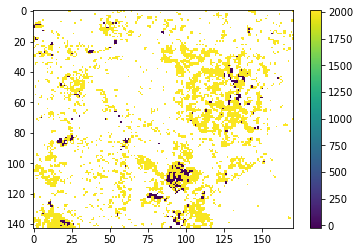

In [32]:
% matplotlib inline
print(np.nanmean(changedates_arr - change))
imshow(changedates_arr - change)
plt.colorbar()

In [34]:
change

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)